In [11]:
sys.path.append('../') #server per fare l'import di file in un'altra directory sullo stesso "livello"
import matplotlib.pyplot as plt
from src.NeuralNetwork import NeuralNetwork, Layer
from src.function import IdentityFunction, SigmoideFunction
from src.load_ds import load_monks_1_train
import numpy as np

In [12]:
# Loading data
target_inputs, target_outputs = load_monks_1_train()



In [13]:
# Monk has an input of 17 features (after one-hot encoding) and 1 output (0 or 1)
# Generating model
input_layer = Layer(num_neurons = 5, num_inputs = 17, activation_function = SigmoideFunction())
hidden_layer = Layer(num_neurons = 2, num_inputs = 5, activation_function = IdentityFunction())
output_layer = Layer(num_neurons = 1, num_inputs = 2, activation_function = SigmoideFunction())

neuralNetwork = NeuralNetwork([input_layer, hidden_layer, output_layer])


In [14]:
# Training

error_history = neuralNetwork.train(target_inputs, target_outputs, epochs = 100, learning_rate = 0.01, regularization_term=0.1, momentum_term=0.5)

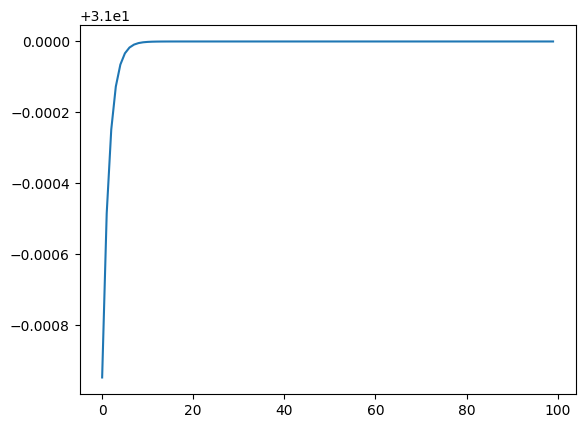

In [15]:
# Show results
plt.plot(error_history)